# Case Study

## Setting the Scene

Imagine you are working for a social media company. The company is concerned with the growing amount of fake news circulatng on it's platform. They have assigned you to investigate how fake news can be recognized and create a method of identifying it. Let's work through this problem together, first by exploring and cleaning the data and then working to classify fake vs factual news stories. We'll also create some plots of our outputs and discuss how we would communicate our findings to stakeholders.

## Import Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# set plot options
plt.rcParams['figure.figsize'] = (12, 8)
default_plot_colour = "#00bfbf"

In [3]:
data = pd.read_csv("../data/fake_news_data.csv")

In [4]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


Text(0.5, 0, 'Classification')

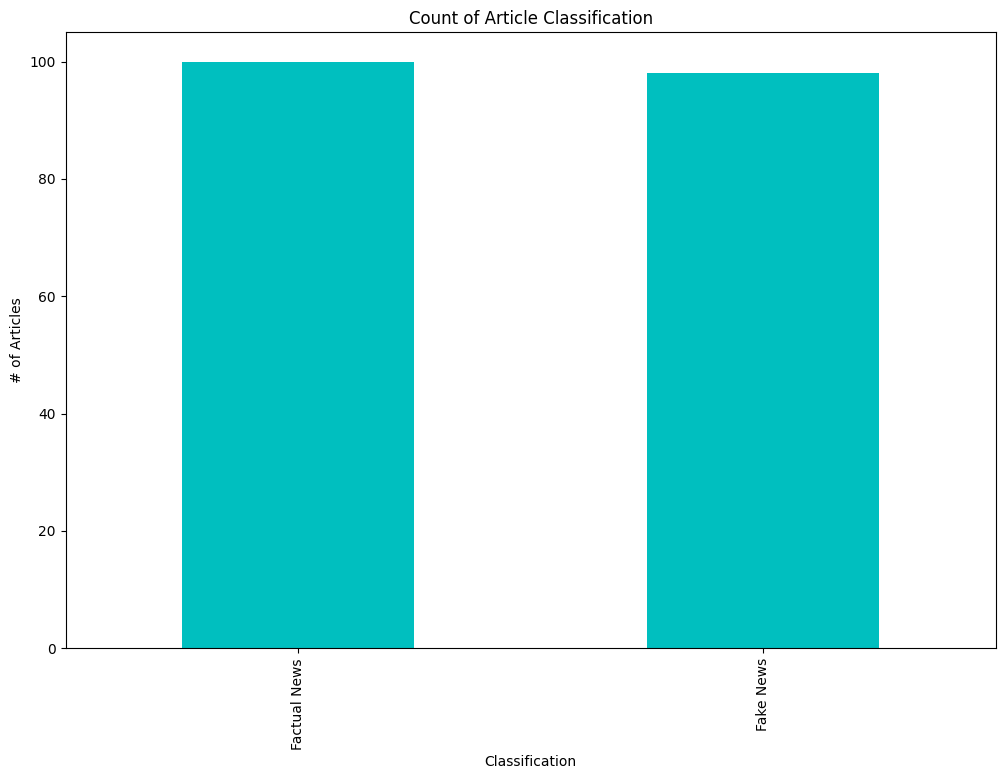

In [6]:
# plot number of fake and factual articles
data['fake_or_factual'].value_counts().plot(kind='bar', color=default_plot_colour)
plt.title('Count of Article Classification')
plt.ylabel('# of Articles')
plt.xlabel('Classification')

## Import packages required for processing and analysis

In [7]:
import seaborn as sns
import spacy
from spacy.tokens import Doc
from spacy import displacy
from spacy import tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaModel, LsiModel, TfidfModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report

## POS Tagging

In [8]:
nlp = spacy.load('en_core_web_sm')

In [9]:
# split data by fake and factual news
fake_news = data[data['fake_or_factual'] == "Fake News"]
fake_news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            98 non-null     object
 1   text             98 non-null     object
 2   date             98 non-null     object
 3   fake_or_factual  98 non-null     object
dtypes: object(4)
memory usage: 3.8+ KB


In [10]:
# split data by fake and factual news
fact_news = data[data['fake_or_factual'] == "Factual News"]
fact_news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 3 to 196
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            100 non-null    object
 1   text             100 non-null    object
 2   date             100 non-null    object
 3   fake_or_factual  100 non-null    object
dtypes: object(4)
memory usage: 3.9+ KB


In [11]:
# create spacey documents - use pipe for dataframe
fake_spaceydocs = list(nlp.pipe(fake_news['text']))
fake_spaceydocs[0]

There are two small problems with your analogy Susan  Jesus was NOT a Muslim and Joseph traveled to Bethlehem with Mary. For anyone who s not paying attention there don t appear to be many female refugees accompanying male Muslim  refugees  to Greece.Susan Sarandon spent the Christmas holiday on the Greek island of Lesbos assisting international organizations with the mounting Syrian refugee crisis   a crisis, she says, that recalls the travails of Joseph and Mary on their way to the Inn in Bethlehem.In a column for the Huffington Post and RYOT, the 69-year-old Oscar-winning actress described meeting a 16-year-old girl who had apparently given birth shortly before arriving on the island. I smile and approach her, but without a translator, our conversation is basic-friendly,  Sarandon wrote of her experience.  She takes the bundle next to her and opens it to me. Inside is a perfect, rosy, newborn. The actress continues:She is beaming, so proud. How did this young girl, just having given

In [12]:
fact_spaceydocs = list(nlp.pipe(fact_news['text'])) 
fact_spaceydocs[0]


WASHINGTON (Reuters) - U.S. Defense Secretary Jim Mattis said on Monday that Russia s bombing of U.S-backed fighters in Syria was being discussed at the highest levels and while a communication link between the two countries had worked to avoid such incidents, the strike over the weekend was a departure.  When you look at the fact that this is a change, you can imagine this is at the highest levels,  Mattis told reporters. Russia s Defense Ministry on Sunday rejected the allegations, saying its planes only targeted Islamic State militants and that it had warned the United States well in advance of its operational plans. 

In [13]:
# create function to extract tags for each document in our data
def extract_token_tags(doc:Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

In [14]:
columns = ["token", "ner_tag", "pos_tag"]

fake_tag_frames: list[pd.DataFrame] = []

for doc in fake_spaceydocs:
    tags = pd.DataFrame(extract_token_tags(doc), columns=columns)
    fake_tag_frames.append(tags)  

# tag fake dataset 
fake_tagsdf = pd.concat(fake_tag_frames, ignore_index=True) 

fact_tag_frames: list[pd.DataFrame] = []

for doc in fact_spaceydocs:
    tags = pd.DataFrame(extract_token_tags(doc), columns=columns)
    fact_tag_frames.append(tags)  

# tag factual dataset 
fact_tagsdf = pd.concat(fact_tag_frames, ignore_index=True)   

In [15]:
fake_tagsdf.head()

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [16]:
fact_tagsdf.head()

,token,ner_tag,pos_tag
0,WASHINGTON,GPE,PROPN
1,(,,PUNCT
2,Reuters,ORG,PROPN
3,),,PUNCT
4,-,,PUNCT


In [17]:
# token frequency count (fake)
pos_counts_fake = fake_tagsdf.groupby(['token','pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_fake.head(10)

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
2449,a,DET,805
0,,SPACE,795
7528,to,PART,767
4921,in,ADP,668
5099,is,AUX,419


In [18]:
# token frequency count (fact)
pos_counts_fact = fact_tagsdf.groupby(['token','pos_tag']).size().reset_index(name='counts').sort_values(by='counts', ascending=False)
pos_counts_fact.head(10)

,token,pos_tag,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789
2093,and,CCONJ,757
4005,in,ADP,671
6205,to,PART,660
4743,on,ADP,482
5567,said,VERB,451


In [19]:
# frequencies of pos tags
pos_counts_fake.groupby(['pos_tag'])['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2586
VERB     1817
PROPN    1672
ADJ       882
ADV       413
NUM       221
PRON       96
ADP        89
AUX        62
SCONJ      51
Name: token, dtype: int64

In [20]:
pos_counts_fact.groupby(['pos_tag'])['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2179
VERB     1539
PROPN    1379
ADJ       747
ADV       263
NUM       205
PRON       79
ADP        70
AUX        43
SCONJ      42
Name: token, dtype: int64

In [21]:
# dive into diferences in nouns
pos_counts_fake[pos_counts_fake.pos_tag == "NOUN"][0:15]

,token,pos_tag,counts
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
3138,campaign,NOUN,44
8011,year,NOUN,44
4581,government,NOUN,41
5213,law,NOUN,40
8013,years,NOUN,40


In [22]:
pos_counts_fact[pos_counts_fact.pos_tag == "NOUN"][0:15]

,token,pos_tag,counts
3738,government,NOUN,71
6618,year,NOUN,64
5901,state,NOUN,57
2360,bill,NOUN,55
1975,administration,NOUN,51
5066,president,NOUN,49
3277,election,NOUN,48
4919,people,NOUN,45
4786,order,NOUN,45
4259,law,NOUN,42


## Named Entities

In [23]:
# top entities in fake news
top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag'] != ""] \
                    .groupby(['token','ner_tag']).size().reset_index(name='counts') \
                    .sort_values(by='counts', ascending=False)
top_entities_fake.head(10)

,token,ner_tag,counts
1730,Trump,PERSON,154
1729,Trump,ORG,152
2129,the,ORG,121
592,Clinton,PERSON,118
718,Donald,PERSON,75
890,Hillary,PERSON,64
1329,Obama,PERSON,59
1179,McCain,PERSON,53
2167,year,DATE,44
1662,Syria,GPE,42


In [24]:
# top entities in fact news
top_entities_fact = fact_tagsdf[fact_tagsdf['ner_tag'] != ""] \
                    .groupby(['token','ner_tag']).size().reset_index(name='counts') \
                    .sort_values(by='counts', ascending=False)
top_entities_fact.head(10)

,token,ner_tag,counts
1968,the,ORG,159
1633,U.S.,GPE,138
1373,Reuters,ORG,131
1615,Trump,PERSON,125
1614,Trump,ORG,124
882,House,ORG,67
1997,year,DATE,63
1646,United,GPE,59
1965,the,GPE,59
1254,Obama,PERSON,55


In [25]:
# create custom palette to ensure plots are consistent
ner_palette = {
    'ORG': sns.color_palette("Set2").as_hex()[0],
    'GPE': sns.color_palette("Set2").as_hex()[1],
    'NORP': sns.color_palette("Set2").as_hex()[2],
    'PERSON': sns.color_palette("Set2").as_hex()[3],
    'DATE': sns.color_palette("Set2").as_hex()[4],
    'CARDINAL': sns.color_palette("Set2").as_hex()[5],
    'PERCENT': sns.color_palette("Set2").as_hex()[6]
}

[Text(0.5, 1.0, 'Most Common Entities in Fake News')]

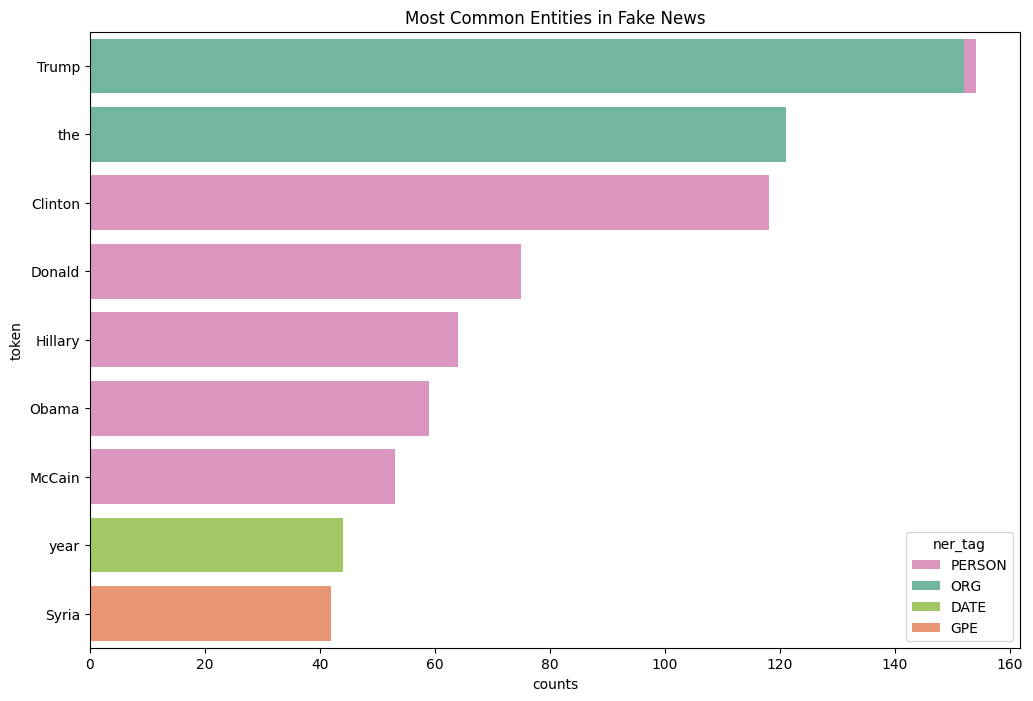

In [26]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fake[0:10],
    orient = 'h',
    dodge=False
) \
.set(title='Most Common Entities in Fake News')

[Text(0.5, 1.0, 'Most Common Entities in Factual News')]

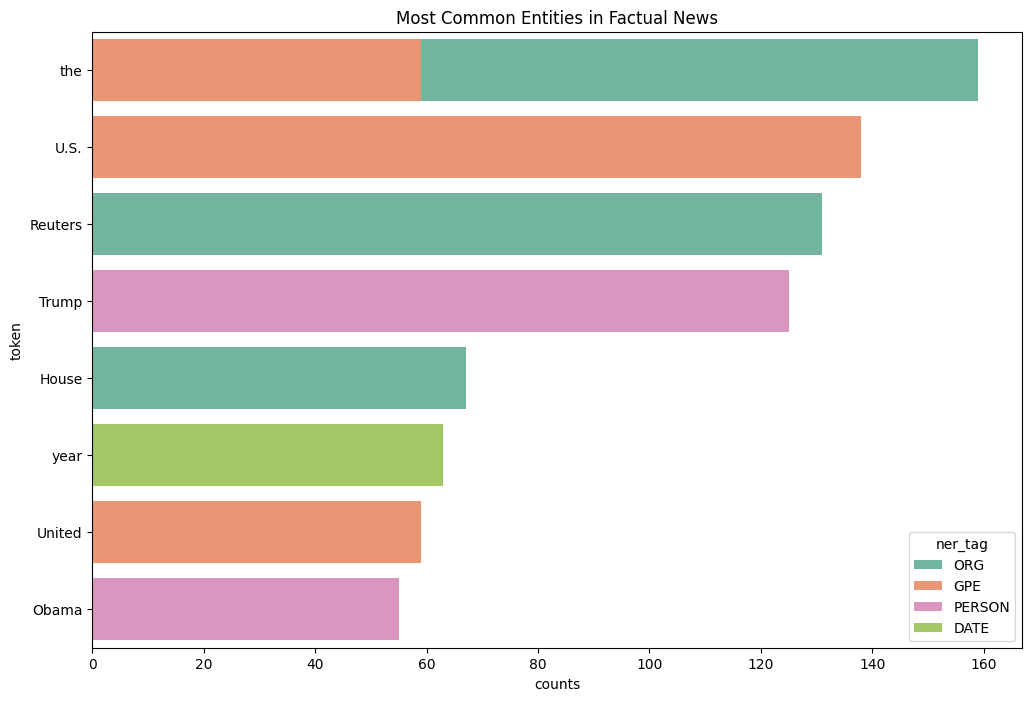

In [27]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fact[0:10],
    orient = 'h',
    dodge=False
) \
.set(title='Most Common Entities in Factual News')

## Text Pre-processing

In [28]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


### Regular Expressions (Regex)

In [29]:
# a lot of the factual news has a location tag at the beginning of the article, let's use regex to remove this
data['text_clean'] = data.apply(lambda x: re.sub(r"^[^-]*-\s*", "", x['text']), axis=1)
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,year-old Oscar-winning actress described meeti...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,Buried in Trump s bonkers interview with New Y...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"Women make up over 50 percent of this country,..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,U.S. Defense Secretary Jim Mattis said on Mond...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,Northern Ireland s political parties are rapid...


### Lowercasing text & removing punctuations

In [30]:
# lowercase 
data['text_clean'] = data['text_clean'].str.lower()
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,year-old oscar-winning actress described meeti...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried in trump s bonkers interview with new y...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"women make up over 50 percent of this country,..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,u.s. defense secretary jim mattis said on mond...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland s political parties are rapid...


In [31]:
# remove punctuation
data['text_clean'] = data.apply(lambda x: re.sub(r"([^\w\s])", "", x['text_clean']), axis=1)
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,yearold oscarwinning actress described meeting...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried in trump s bonkers interview with new y...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,women make up over 50 percent of this country ...
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,us defense secretary jim mattis said on monday...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland s political parties are rapid...


### Removing Stopwords

In [32]:
# stop words
en_stopwords = stopwords.words('english')
print(en_stopwords) # check this against our most frequent n-grams

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [33]:
data['text_clean'] = data['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (en_stopwords)]))
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,yearold oscarwinning actress described meeting...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried trump bonkers interview new york times ...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,women make 50 percent country grossly underrep...
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,us defense secretary jim mattis said monday ru...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland political parties rapidly run...


### Tokenization

In [34]:
# tokenize 
data['text_clean'] = data.apply(lambda x: word_tokenize(x['text_clean']), axis=1)
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[women, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[us, defense, secretary, jim, mattis, said, mo..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, parties, rapidl..."


### Lemmatization

In [35]:
# lemmatize
lemmatizer = WordNetLemmatizer()
data["text_clean"] = data["text_clean"].apply(lambda tokens: [lemmatizer.lemmatize(token) for token in tokens])
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,..."


### N-grams

In [36]:
from itertools import chain

# safer flatten than sum(..., [])
tokens_clean = list(chain.from_iterable(data["text_clean"]))

unigram_tuples = list(nltk.ngrams(tokens_clean, 1))

# most common unigrams after preprocessing
unigrams = pd.Series(unigram_tuples).value_counts().reset_index().head(10)
print(unigrams)


           index  count
0        (said,)    560
1       (trump,)    520
2           (u,)    255
3       (state,)    250
4   (president,)    226
5       (would,)    210
6         (one,)    141
7        (year,)    128
8  (republican,)    128
9        (also,)    124


/var/folders/n5/c3bqxwvx223256p_xxly88n80000gp/T/ipykernel_73712/4019870307.py:3: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x = "count",


[Text(0.5, 1.0, 'Most Common Unigrams After Preprocessing')]

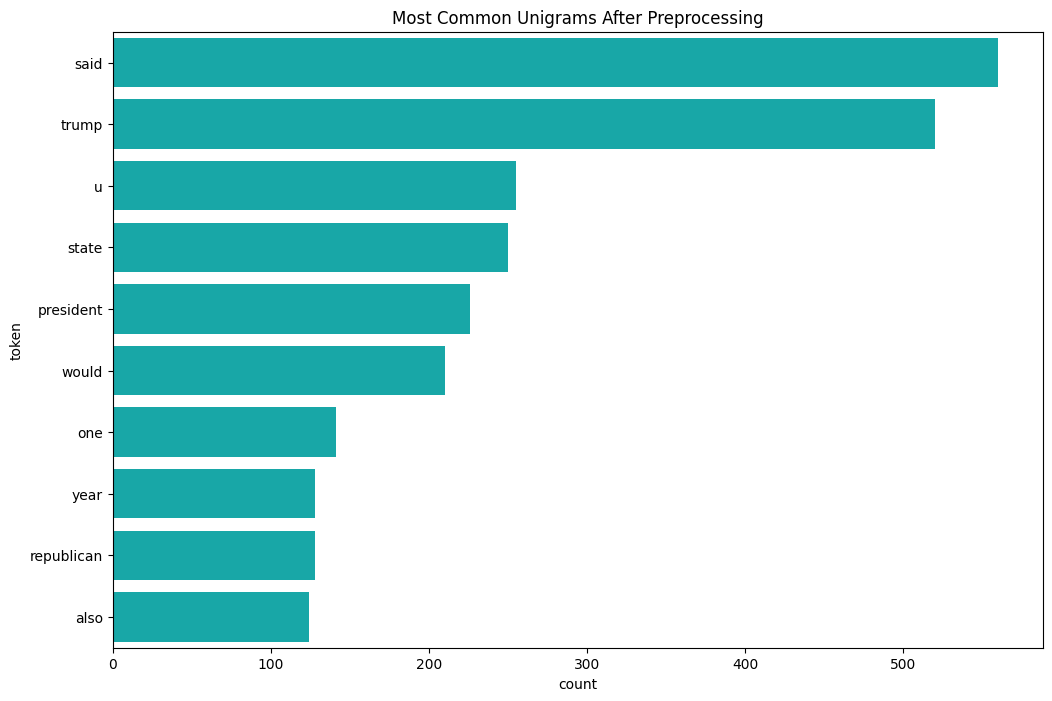

In [37]:
unigrams['token'] = unigrams['index'].apply(lambda x: x[0]) # extract the token from the tuple so we can plot it

sns.barplot(x = "count", 
            y = "token", 
            data=unigrams,
            orient = 'h',
            palette=[default_plot_colour],
            hue = "token", legend = False)\
.set(title='Most Common Unigrams After Preprocessing')

In [38]:
bigram_tuples = list(nltk.ngrams(tokens_clean, 2))

# most common bigrams after preprocessing
bigrams = (pd.Series(bigram_tuples).value_counts()).reset_index().head(10)
print(bigrams)

                 index  count
0      (donald, trump)     92
1      (united, state)     80
2       (white, house)     72
3  (president, donald)     42
4   (hillary, clinton)     31
5          (new, york)     31
6         (image, via)     29
7     (supreme, court)     29
8     (official, said)     26
9        (food, stamp)     24


/var/folders/n5/c3bqxwvx223256p_xxly88n80000gp/T/ipykernel_73712/3995889105.py:4: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x = "count",


[Text(0.5, 1.0, 'Most Common Bigrams After Preprocessing')]

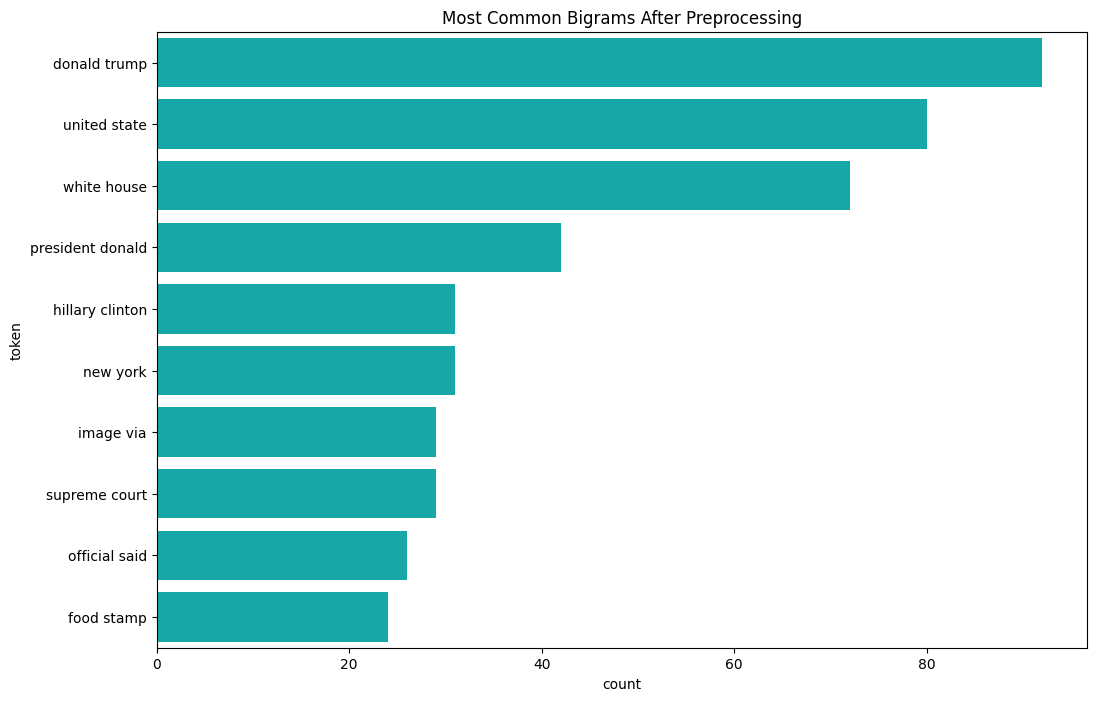

In [39]:
# tuple -> readable text
bigrams['token'] = bigrams['index'].apply(lambda x: f"{x[0]} {x[1]}") # turn the bigram tuple into readable text for plotting

sns.barplot(x = "count", 
            y = "token", 
            data=bigrams,
            orient = 'h',
            palette=[default_plot_colour],
            hue = "token", legend = False)\
.set(title='Most Common Bigrams After Preprocessing')

## Sentiment Analysis

In [40]:
# use vader so we also get a neutral sentiment count
vader_sentiment = SentimentIntensityAnalyzer()

In [41]:
data['vader_sentiment_score'] = data['text'].apply(lambda review: vader_sentiment.polarity_scores(review)['compound'])

In [42]:
# create labels
bins = [-1, -0.1, 0.1, 1]
names = ['negative', 'neutral', 'positive']

data['vader_sentiment_label'] = pd.cut(data['vader_sentiment_score'], bins, labels=names)

<Axes: xlabel='vader_sentiment_label'>

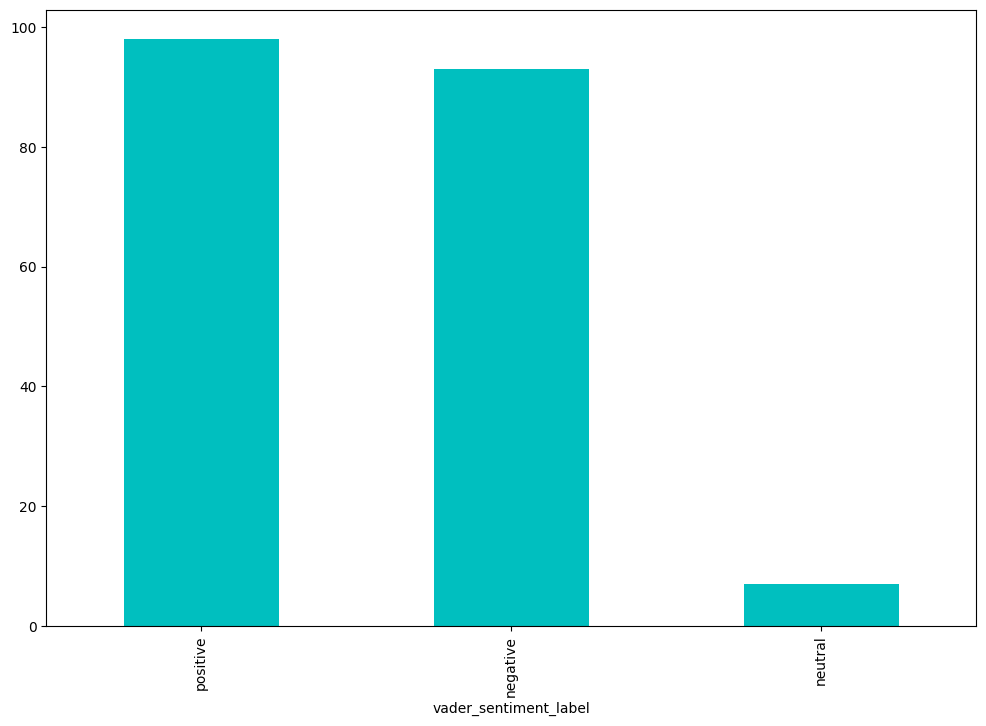

In [43]:
data['vader_sentiment_label'].value_counts().plot.bar(color=default_plot_colour)

/var/folders/n5/c3bqxwvx223256p_xxly88n80000gp/T/ipykernel_73712/3014756626.py:1: UserWarning: The palette list has more values (6) than needed (3), which may not be intended.
  sns.countplot(


[Text(0.5, 1.0, 'Sentiment by News Type')]

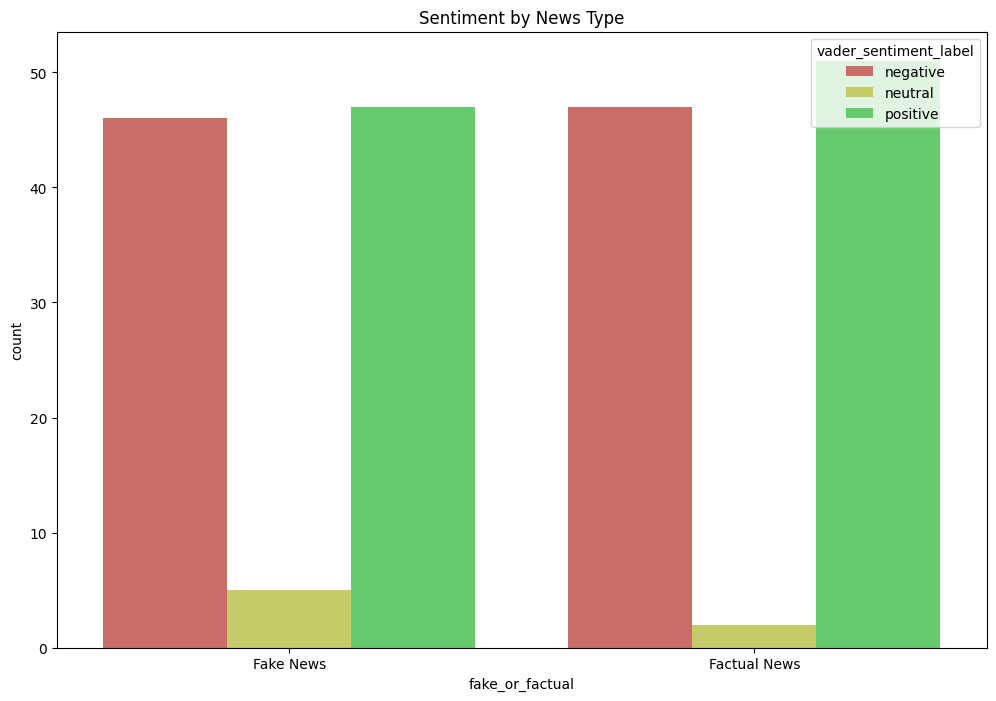

In [44]:
sns.countplot(
    x = 'fake_or_factual',
    hue = 'vader_sentiment_label',
    palette = sns.color_palette("hls"),
    data = data
) \
.set(title='Sentiment by News Type')

## Vectorizing Text

### Bag of Words

In [45]:
fake_news_text = data[data['fake_or_factual'] == "Fake News"]['text_clean'].reset_index(drop=True) # filter fake news
dictionary_fake = corpora.Dictionary(fake_news_text) # create a dictionary for the fake news text
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text] # fake news data vectorization

### TF-IDF

In [46]:
def tfidf_corpus(doc_term_matrix):
    # create a corpus using tfidf vectorization
    tfidf = TfidfModel(corpus=doc_term_matrix, normalize=True)
    corpus_tfidf = tfidf[doc_term_matrix]
    return corpus_tfidf

In [47]:
# create tfidf representation
corpus_tfidf_fake = tfidf_corpus(doc_term_fake) # coverts bag of words to tfidf

## Topic Modelling

### Latent Dirichlet Allocation (LDA)

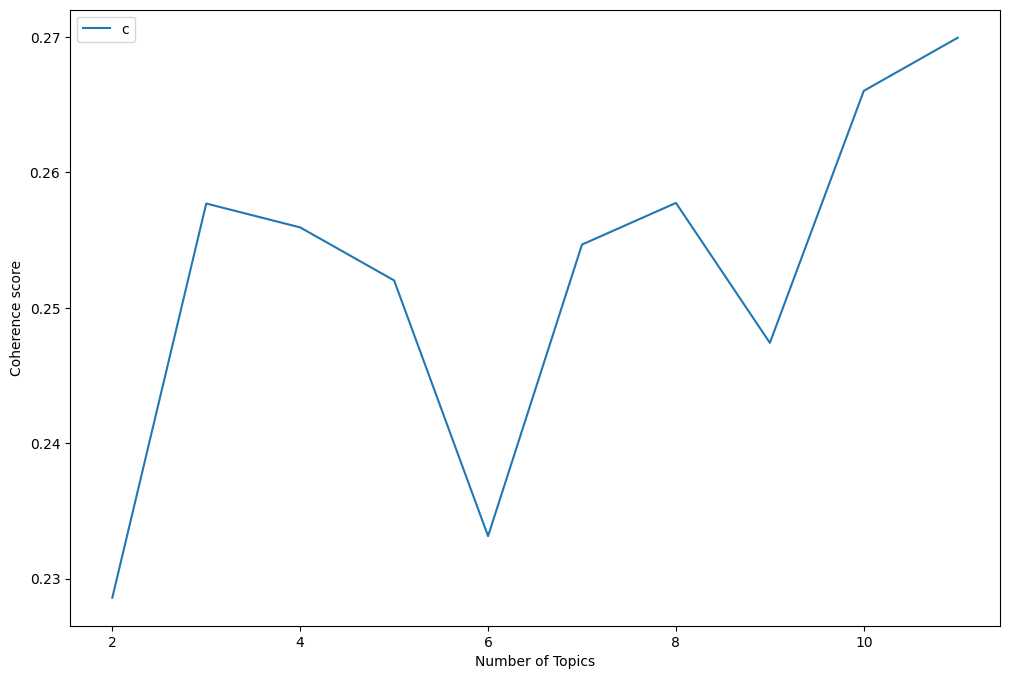

In [48]:
# generate coherence scores to determine an optimum number of topics
coherence_values = []
model_list = []

min_topics = 2
max_topics = 11

for num_topics_i in range(min_topics, max_topics+1):
    model = LdaModel(doc_term_fake, num_topics=num_topics_i, id2word = dictionary_fake)
    model_list.append(model)
    coherence_model = CoherenceModel(model=model, texts=fake_news_text, dictionary=dictionary_fake, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())
    
plt.plot(range(min_topics, max_topics+1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [49]:
# create lda model
num_topics_fake = 6 

lda_fake = LdaModel(corpus=doc_term_fake, id2word=dictionary_fake, num_topics=num_topics_fake)

lda_fake.print_topics(num_topics=num_topics_fake, num_words=10)

[(0,
  '0.010*"trump" + 0.006*"said" + 0.005*"clinton" + 0.004*"would" + 0.004*"u" + 0.004*"hillary" + 0.004*"time" + 0.004*"state" + 0.003*"woman" + 0.003*"one"'),
 (1,
  '0.005*"said" + 0.005*"would" + 0.004*"state" + 0.004*"trump" + 0.003*"u" + 0.003*"president" + 0.003*"stamp" + 0.003*"time" + 0.003*"food" + 0.003*"email"'),
 (2,
  '0.006*"trump" + 0.005*"clinton" + 0.004*"state" + 0.004*"president" + 0.004*"woman" + 0.004*"said" + 0.004*"people" + 0.004*"would" + 0.003*"time" + 0.003*"republican"'),
 (3,
  '0.011*"trump" + 0.004*"u" + 0.003*"would" + 0.003*"woman" + 0.003*"said" + 0.003*"student" + 0.003*"state" + 0.003*"one" + 0.003*"syria" + 0.003*"people"'),
 (4,
  '0.016*"trump" + 0.005*"clinton" + 0.004*"one" + 0.004*"republican" + 0.004*"president" + 0.004*"u" + 0.004*"said" + 0.003*"state" + 0.003*"donald" + 0.003*"like"'),
 (5,
  '0.015*"trump" + 0.007*"president" + 0.006*"said" + 0.006*"republican" + 0.004*"party" + 0.003*"one" + 0.003*"state" + 0.003*"image" + 0.003*"tim

### Latent Semantic Analysis (LSA)

In [50]:
def get_coherence_scores(corpus, dictionary, text, min_topics, max_topics):
    # generate coherence scores to determine an optimum number of topics
    coherence_values = []
    model_list = []
    for num_topics_i in range(min_topics, max_topics+1):
        model = LsiModel(corpus, num_topics=num_topics_i, id2word = dictionary, random_seed=0)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=text, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
    # plot results
    plt.plot(range(min_topics, max_topics+1), coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

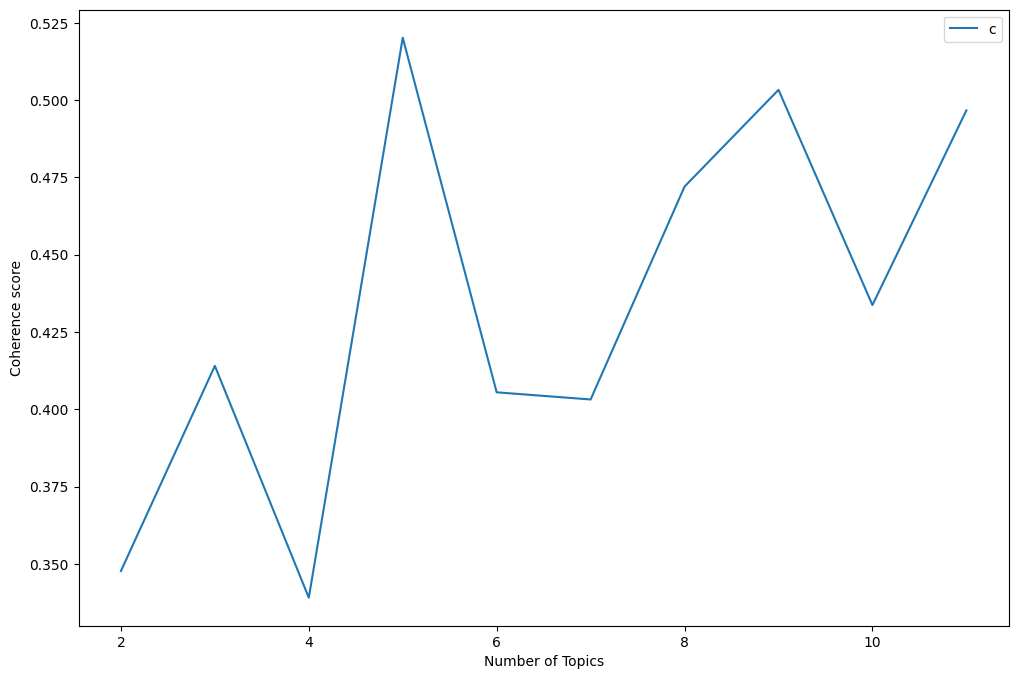

In [51]:
# coherence scores for fake news data
get_coherence_scores(corpus_tfidf_fake, dictionary_fake, fake_news_text, min_topics=2, max_topics=11)

In [52]:
# model for fake news data
lsa_fake = LsiModel(corpus_tfidf_fake, id2word=dictionary_fake, num_topics=5)
lsa_fake.print_topics()

[(0,
  '0.218*"trump" + 0.135*"clinton" + 0.094*"woman" + 0.087*"president" + 0.086*"republican" + 0.085*"obama" + 0.084*"party" + 0.083*"school" + 0.081*"said" + 0.079*"time"'),
 (1,
  '-0.299*"boiler" + -0.253*"room" + -0.250*"acr" + -0.186*"jay" + -0.185*"animal" + -0.176*"episode" + -0.147*"analysis" + -0.122*"dyer" + -0.119*"savant" + -0.119*"moralist"'),
 (2,
  '-0.219*"school" + 0.195*"clinton" + 0.163*"conference" + -0.151*"county" + -0.137*"student" + 0.120*"press" + 0.116*"trump" + 0.112*"hillary" + -0.101*"love" + 0.095*"email"'),
 (3,
  '0.375*"flynn" + 0.151*"russian" + 0.111*"email" + 0.109*"30" + 0.101*"department" + 0.100*"information" + 0.100*"nana" + 0.099*"official" + 0.098*"mccain" + -0.096*"trump"'),
 (4,
  '0.235*"trump" + 0.223*"flynn" + 0.166*"conference" + -0.165*"clinton" + -0.153*"dnc" + -0.151*"sander" + -0.127*"email" + 0.111*"press" + -0.109*"rich" + 0.084*"tax"')]

## Predict fake or factual news 

In [53]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[yearold, oscarwinning, actress, described, me...",-0.3660,negative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,negative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,negative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


In [54]:
# X = [','.join(map(str, l)) for l in data['text_clean']]
# Y = data['fake_or_factual']

# # text vectorization - CountVectorizer
# countvec = CountVectorizer()
# countvec_fit = countvec.fit_transform(X)
# bag_of_words = pd.DataFrame(countvec_fit.toarray(), columns = countvec.get_feature_names_out())
# bag_of_words.head()

In [55]:
X = [' '.join(map(str, l)) for l in data['text_clean']]  # space-separated tokens
Y = data['fake_or_factual']

countvec = CountVectorizer()
countvec_fit = countvec.fit_transform(X)

bag_of_words = pd.DataFrame.sparse.from_spmatrix(countvec_fit, columns=countvec.get_feature_names_out())
bag_of_words.head()

,01,03,05,08441,10,100,1000,10000,1000000000000000,1002,...,zimbabwe,zimbabwean,zimmerman,zina,zionism,zoe,zone,zoom,zouka,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# split into train and test data
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, Y, test_size=0.3)

In [57]:
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

In [58]:
y_pred_lr = lr.predict(X_test)

In [59]:
accuracy_score(y_pred_lr, y_test)

0.9

In [60]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.85      0.97      0.90        29
   Fake News       0.96      0.84      0.90        31

    accuracy                           0.90        60
   macro avg       0.91      0.90      0.90        60
weighted avg       0.91      0.90      0.90        60



In [61]:
svm = SGDClassifier().fit(X_train, y_train)

In [62]:
y_pred_svm = svm.predict(X_test)

In [63]:
accuracy_score(y_pred_svm, y_test)

0.8666666666666667

In [64]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.80      0.97      0.88        29
   Fake News       0.96      0.77      0.86        31

    accuracy                           0.87        60
   macro avg       0.88      0.87      0.87        60
weighted avg       0.88      0.87      0.87        60

